# Krzysztof Zając NLP Assigment

Solution to test assignment for datascience recruitment position. <br>
Notebook solves classification problem for HTML documents, it infers if the web page contains information about cancer tumorboard.

### Setup

In [1]:
root_path = ''  # path to project root directory hidden

In [41]:
import os

import numpy as np
import nltk
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from bs4 import BeautifulSoup
from gensim.parsing import preprocessing as parsing  # not to shadow sklearn package name
from IPython.display import HTML
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [4]:
sns.set()
plt.rcParams["figure.figsize"] = (16, 8)

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Utils

Thouse should be placed in source code and probably tested, since such functions can be reused often, but for the purpose of the notebook's simple usage is enough. 

In [6]:
def detailed_value_counts(column: pd.Series, dropna: bool = True) -> pd.DataFrame:
    """
    Computes detailed value counts with absolute values and ratios in % rounded to 2 decimal places

    :param column: pandas series to compute stats for
    :param dropna: if True do not include Nan values in count

    :return: DataFrame with two columns
    """
    result = pd.concat([
            column.value_counts(dropna=dropna),
            column.value_counts(normalize=True, dropna=dropna).apply(lambda value: f"{value:.2%}"),
        ], axis=1,
    )
    result.columns = ["Count", "Ratio"]

    return result


def describe_text_lengths(column: pd.Series, separator: str = " ", precision: int = 2) -> pd.Series:
    """
    Describes lengths of text column

    :param column: pandas series with textual data
    :param separator: substring to split on, defaults to whitespace, if "" given lengths are in tokens
    :param precision: rounding off precision for numerical values

    :return: stats of lengths of items in pandas column
    """
    column = column.copy(deep=True)
    column = column.replace(to_replace=np.nan, value="")

    return column.apply(lambda item: len(item.split(separator))).describe().apply(round, args=(precision,))


### Dataset
Files contain document IDs, which are stored in `htmls` directory and corresponding correct classes.

In [7]:
train_df = pd.read_csv(os.path.join(root_path, "train.csv"))
test_df = pd.read_csv(os.path.join(root_path, "test.csv"))

Add IDs are unique, one ID is one HTML document.

In [8]:
train_df["doc_id"].unique().all()

True

The classes are not balanced well, which can be a trouble for classifier models. 

In [9]:
detailed_value_counts(train_df["label"])

Count   Ratio
2     59  59.00%
1     32  32.00%
3      9   9.00%

HTML documents are in German, which could make it harder to use pre-trained embedding. 

In [10]:
index = np.random.randint(len(train_df))
# uncomment to see sample HTML document
# this takes a lot of space in notebook
# HTML(filename=f'{root_path}/htmls/{train_df["doc_id"].iloc[index]}.html')

# Algorithm

Since there is only a 100 labeled examples traditional machine learning approach could be difficult to perform. Instead of running typical ML pipeline the main algorithm for this task will be One Shot learning with Siamese Neural Network using pretrained model to create text embedding. This method is usually best for working with classification problems with extreamly limited amount of data and it does not approach to create typical classification, but to use neural networks to learn similarity function between example and then compare new samples with known anchors and chose the most similar as category. Smallest category has 9 samples, which would leave around 6 for training and 3 for validation, which is neccessary in any ML model!   

### DataGenerator

Create data generator class returning batched document, performing preprocessing with `BeautifulSoup` on the fly. It means that dataset does not have to be loaded into memory, but it is fetched on demand. `TesorFlow` library is very useful for such datasets.

In [11]:
class OneShotDataGenerator(tf.keras.utils.Sequence):
    """
    Data generator for multiclass one shot learning problems
    """
    def __init__(self, data, targets, n_classes, n_batches, batch_size=10):
        """
        :param data: list of inputs for the mode
        :param targets: list of classes used as labels
        :param n_classes: number of different one shot classes
        :param n_batches: number of batches to generate,
                          should be N*n_classes, so each class gets a fair number of batches during each epoch
        :param batch_size: size of single batch in training
        """
        super(OneShotDataGenerator, self).__init__()

        self.data = data
        self.targets = targets
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.classes = []
        self.stop_words = set(nltk.corpus.stopwords.words("german"))
        self.stemmer = nltk.stem.SnowballStemmer("german")

    def __len__(self):
        return self.n_batches

    def __getitem__(self, index):
        """Returns single data batch with binary classification labels"""
        class_id = np.random.randint(1, self.n_classes + 1)
        self.classes.append(class_id)
        
        samples = tf.concat([
            self.positive_samples(class_id, n_samples=self.batch_size // 2), 
            self.negative_samples(class_id, n_samples=self.batch_size // 2),
        ], axis=0)
        
        anchors = self.positive_samples(class_id, n_samples=self.batch_size)
        targets = tf.concat([tf.ones(self.batch_size // 2), tf.zeros(self.batch_size // 2)], axis=0)
        ordering = tf.random.shuffle(tf.range(self.batch_size))

        samples = self.get_files(tf.gather(samples, ordering))
        anchors = self.get_files(tf.gather(anchors, ordering))

        return tf.stack([samples, anchors], axis=1), tf.gather(targets, ordering)

    

    def load_file(self, file_index: int) -> str:
        """Loads HTML file for given index"""
        with open(f"{root_path}/htmls/{file_index}.html", "r", encoding="latin1") as file:
            content = file.read()

        return content

    def preprocess(self, text: str) -> str:
        """
        Applied preprocessing in place, clean HTML tags with BeautifulSoup
        and removes unneccessary whitespaces, punctuation and tags with gensim
        """
        soup = BeautifulSoup(text, features="lxml")
        
        for script in soup(["script", "style"]):
            script.decompose()

        clean_text = soup.get_text(" ")
        clean_text = parsing.strip_multiple_whitespaces(clean_text)
        clean_text = parsing.strip_non_alphanum(clean_text)
        clean_text = parsing.strip_punctuation(clean_text)
        clean_text = parsing.strip_tags(clean_text)
        clean_text = [word for word in clean_text.split(" ") if word not in self.stop_words]
        clean_text = [self.stemmer.stem(word) for word in clean_text]
        clean_text = " ".join(clean_text)

        return clean_text

    def test_input(self, sample, n_examples: int = 5) -> tf.Tensor:
        """Create test input for given data sample"""
        test_anchors = tf.concat([self.positive_samples(class_id, n_samples=n_examples) for class_id in range(1, self.n_classes + 1)], axis=0)
        test_anchors = self.get_files(test_anchors)
        samples = tf.repeat(self.preprocess(self.load_file(sample)), n_examples * self.n_classes)
        
        return tf.stack([samples, test_anchors], axis=1)

    def get_files(self, samples: tf.Tensor) -> tf.Tensor:
        """Converts file IDs to text data"""
        return [self.preprocess(self.load_file(file_index)) for file_index in samples.numpy().tolist()]

    def positive_samples(self, category: int, n_samples: int) -> tf.Tensor:
        """Returns positive samples for given class"""
        examples = tf.squeeze(tf.where(self.targets == category))
        samples = tf.random.uniform(shape=(n_samples,), maxval=len(examples), dtype=tf.int32)

        return tf.gather(tf.gather(self.data, examples), samples)

    def negative_samples(self, category: int, n_samples: int) -> tf.Tensor:
        """Returns negative samples for given class"""
        examples = tf.squeeze(tf.where(self.targets != category))
        samples = tf.random.uniform(shape=(n_samples,), maxval=len(examples), dtype=tf.int32)

        return tf.gather(tf.gather(self.data, examples), samples)

Use 30% of the data for testing. This removes a significant portion of data, but is neccessary for the experiment.

In [24]:
train_x, test_x, train_y, test_y = train_test_split(train_df["doc_id"].values, train_df["label"].values, test_size=0.3, random_state=34)
generator = OneShotDataGenerator(data=train_x, targets=train_y, n_classes=3, n_batches=100, batch_size=2)

Classes are not equally balanced, but one shot learning will hopefully account for that.

In [25]:
detailed_value_counts(pd.Series(train_y))

Count   Ratio
2     39  55.71%
1     24  34.29%
3      7  10.00%

Create TF-IDF vectorizer for whole dataset.

In [62]:
vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000, output_mode="tf-idf")
# adapt using train dataset
vectorizer.adapt([generator.preprocess(generator.load_file(file_index)) for file_index in train_x.tolist()])

### Model

Use model is a simplified Siamese neural network. It does not use triplet loss, but a binary classifiaction. <br>
It aims to learn similarity function between classes, objects belonging to the same class have label 1 and those belonging to different classes have id 0.

In [63]:
class SiameseFeedForwardModel(tf.keras.Model):
    def __init__(self):
        super(SiameseFeedForwardModel, self).__init__()

        self.network = tf.keras.Sequential([
            vectorizer,
            tf.keras.layers.InputLayer(input_shape=(1000,)),  # vocab size set 5000
            tf.keras.layers.Dense(units=128, activation="relu"),
        ])

        self.dot = tf.keras.layers.Dot(axes=1, normalize=True)
        
    def call(self, inputs, *args, **kwargs):
        anchors = inputs[:, 0]
        targets = inputs[:, 1]

        left = self.network(anchors)
        right = self.network(targets)

        return self.dot([left, right])

In [64]:
model = SiameseFeedForwardModel()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

Model achieves almost 90% accuracy in one shot learning during training, but this is not a relevant information. It needs to be avalauted using unseen data. High accuracy during training, can be caused by overfitting, which is bad. 

Callback monitors loss function, instead of validation loss or metrics, since data is at scarce and using sepearate dataset for validation, would require additional samples. 

In [65]:
history = model.fit(generator, epochs=3, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)])

Epoch 1/3
100/100 [==============================] - 34s 330ms/step - loss: 0.8447 - binary_accuracy: 0.5689
Epoch 2/3
100/100 [==============================] - 34s 337ms/step - loss: 0.5506 - binary_accuracy: 0.7031
Epoch 3/3
100/100 [==============================] - 33s 334ms/step - loss: 0.4559 - binary_accuracy: 0.7699


Display the count of classes drawn during training. It should be close to uniform distribution, so class 3 is not misrepresented and model learns the similarity function between all classes. It is still prone to overfitting, because it sees only 7 examples of class 3, so it is likely to missclassify those during testing.

In [66]:
detailed_value_counts(pd.Series(generator.classes))

Count   Ratio
2    411  34.14%
3    397  32.97%
1    396  32.89%

Use 5 random anchors from each class and evalute average similarity across those classes. Model should have higher similary for 1 of the classes, which would mean the sample probably belongs to this class.

In [67]:
examples = 5
outputs = np.asarray([model(generator.test_input(x, n_examples=examples)) for x in test_x.tolist()])
outputs.shape

(30, 15, 1)

In [68]:
outputs = outputs.reshape(30, 3, examples).mean(axis=2)
predictions = np.argmax(outputs, axis=1) + 1

Model does not do well on test data set. It can be caused by overfitting to training data and very small amount of samples. This is very hard to solve using, such as small dataset.

In [69]:
print(metrics.classification_report(y_true=test_y, y_pred=predictions, zero_division=0.0))

              precision    recall  f1-score   support

           1       0.55      0.75      0.63         8
           2       0.89      0.80      0.84        20
           3       1.00      0.50      0.67         2

    accuracy                           0.77        30
   macro avg       0.81      0.68      0.71        30
weighted avg       0.80      0.77      0.77        30



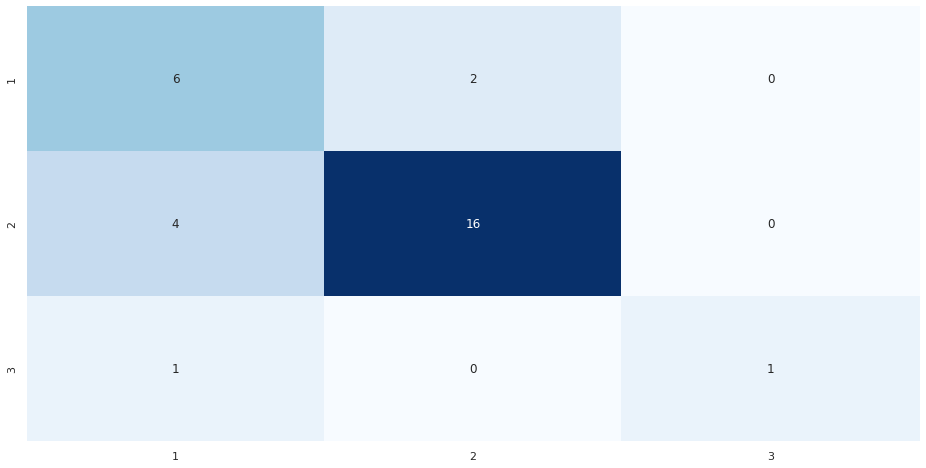

In [70]:
cnf_matrix = metrics.confusion_matrix(y_true=test_y, y_pred=predictions)
_ = sns.heatmap(cnf_matrix, cbar=False, annot=True, fmt="d", cmap="Blues", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])

# Benchmark

Use simple sklearn pipeline to compare results from the algorithm. Use TF-IDF vectorizer and SVC model. Reuse fitted vectorizer from tensorflow. 

In [43]:
features = vectorizer([generator.preprocess(generator.load_file(file_index)) for file_index in train_x.tolist()])

In [44]:
classifier = SVC(kernel="linear")
classifier.fit(features, train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Evaluate model using the same metrics as one shot learning.

In [45]:
test_features = vectorizer([generator.preprocess(generator.load_file(file_index)) for file_index in test_x.tolist()])
predictions = classifier.predict(test_features)

SVC pipeline perfomrs a bit worse than Siamese neural network. It mostly predicts examples from 2 class, which is the largets. Macro average accuracy is much lower.

In [46]:
print(metrics.classification_report(y_true=test_y, y_pred=predictions, zero_division=0.0))

              precision    recall  f1-score   support

           1       0.25      0.25      0.25         8
           2       0.73      0.80      0.76        20
           3       0.00      0.00      0.00         2

    accuracy                           0.60        30
   macro avg       0.33      0.35      0.34        30
weighted avg       0.55      0.60      0.57        30



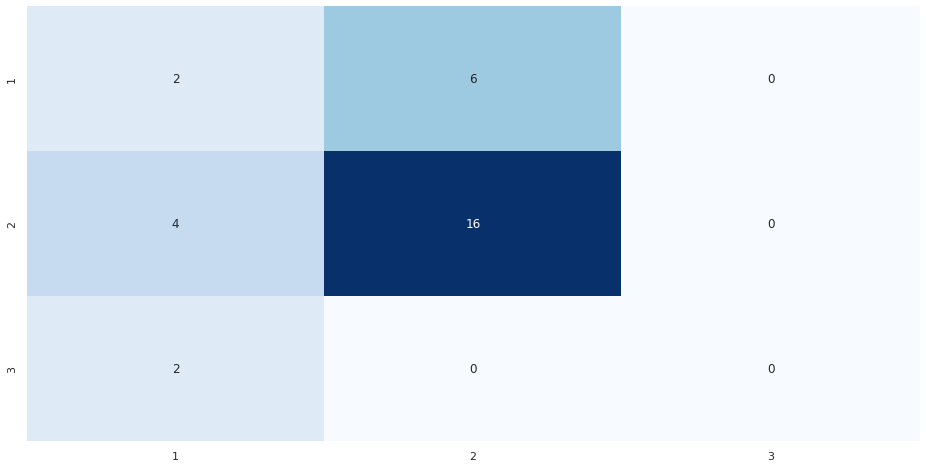

In [47]:
cnf_matrix = metrics.confusion_matrix(y_true=test_y, y_pred=predictions)
_ = sns.heatmap(cnf_matrix, cbar=False, annot=True, fmt="d", cmap="Blues", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])